### 2.Data Preprocessing

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
import geohash as gh
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [72]:
df = pd.read_csv("Airbnb_NYC_2019.csv")

In [73]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [74]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [75]:
df.shape

(48895, 16)

#### 2.1 Dealing with missing values

In [76]:
# check missing values 
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can keep the missing values for `name`, `host_name`, since we are not going to using these variables in the model anyways. Even if we were, it may be worth it to keep them in the model to decide what the output of a null host_name would be.
As for `last_review` and `reviews_per_month`, we believe that `last_month` is a variable that we would never include in the model. For `reviews_per_month`, we can replace all the missing values to 0, because 0 should be the correct value if a review has never been made for that listing.

The empty values for name, host_name, and last reviews can be dropped, since they seem non-menaingful to impute. We can replace the empty values for reviews per month with 0 values, becuase this means there is no review per month. 

In [77]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0.00)
df['name'] = df['name'].fillna('')
df['host_name'] = df['host_name'].fillna('')

In [78]:
#check missing values again 
df.isna().sum()

id                                    0
name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [79]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


#### 2.2 Omit extreme outliers and invalid values

There are also be some erroneous values in the dataset. For example, there are instances where the price is 10,000 per day despite being a single private room.

For `price`, we omit from the dataset if the price is above 3,000 per day or costs 0 per day. For `minimum_nights`, we omit if the number of minimum nights is above 60 days per month. For `reviews_per_month`, we omit if the number is above 15 per month, as it is very unlikely a listing could get 15 reviews a month, which is a review every 2 days.

In [80]:
df_omit = df[(df['price'] > 0) & (df['price'] <= 3000) & (df['minimum_nights'] <= 60) & (df['reviews_per_month'] <= 15)]

#### 2.3 What are some components that need to take into considerations for house price?

geography (`latitude`, `longitude`), `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `calculated_host_listings_count`, `availability_365`. Thus we can exclude `id`, `host_id`, `last_review` from our considerations for training data. We also exclude `neigbourhood_group` from our analysis as we believe this too closely overlaps with coordinate data.

In [81]:
# generate training data 
# drop unrelated information
# neighborhood has the same information as latitude and longitude, thus enighborhood can be dropped
df_relevant = df_omit.drop(['id','name', 'host_name', 'host_id','neighbourhood','last_review'], axis=1)

In [82]:
df_relevant.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [83]:
#check number of unique values in each columne to decide what processing technique to use 
df_relevant.nunique()

neighbourhood_group                   5
latitude                          18995
longitude                         14674
room_type                             3
price                               639
minimum_nights                       50
number_of_reviews                   391
reviews_per_month                   927
calculated_host_listings_count       47
availability_365                    366
dtype: int64

#### 2.4 One hot encoding for categorical variables

In [84]:
print(df_relevant['room_type'].unique())
print(df_relevant['neighbourhood_group'].unique())

['Private room' 'Entire home/apt' 'Shared room']
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


Based on the number of unique values and data type for each column. We can apply the following encoding method for text preprocessing: 

1. one hot encoding for neighbor group
2. create grouping for latitude and longitude first? then encode?
3.label encode for room type since size matters
4. conduct normalization/ standardization for all continuous data

In [85]:
#exclude label
df_relevant.drop(['price'], axis = 1, inplace= True)

In [86]:
df_relevant.head()

,neighbourhood_group,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,10,9,0.10,1,0


In [87]:
df_relevant_encode = pd.get_dummies(df_relevant, prefix = ['neighbourhood_group', 'room_type'], columns = ['neighbourhood_group', 'room_type'])
df_relevant_label = pd.get_dummies(df_relevant, prefix = ['neighbourhood_group'], columns = ['neighbourhood_group'])
le = preprocessing.LabelEncoder()
le.fit(['Shared room','Private room','Entire home/apt'])
df_relevant_label['room_type'] = le.transform(df_relevant_label['room_type'])

#### 2.5 Geohash for latitude and longitude

In [88]:
# create geohash code for geographical data 
df_relevant_encode['geohash']=df_relevant_encode.apply(lambda x: gh.encode(x['latitude'], x['longitude'], precision=7), axis=1)

In [89]:
df_relevant_encode.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,geohash
0,40.64749,-73.97237,1,9,0.21,6,365,0,1,0,0,0,0,1,0,dr5rhxw
1,40.75362,-73.98377,1,45,0.38,2,355,0,0,1,0,0,1,0,0,dr5ru6y
2,40.80902,-73.94190,3,0,0.00,1,365,0,0,1,0,0,0,1,0,dr72jmj
3,40.68514,-73.95976,1,270,4.64,1,194,0,1,0,0,0,1,0,0,dr5rmn8
4,40.79851,-73.94399,10,9,0.10,1,0,0,0,1,0,0,1,0,0,dr72j75


In [90]:
#drop latltitude longitude
df_relevant_encode.drop(['latitude', 'longitude'], axis = 1, inplace= True)

In [91]:
df_relevant_encode.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,geohash
0,1,9,0.21,6,365,0,1,0,0,0,0,1,0,dr5rhxw
1,1,45,0.38,2,355,0,0,1,0,0,1,0,0,dr5ru6y
2,3,0,0.00,1,365,0,0,1,0,0,0,1,0,dr72jmj
3,1,270,4.64,1,194,0,1,0,0,0,1,0,0,dr5rmn8
4,10,9,0.10,1,0,0,0,1,0,0,1,0,0,dr72j75


In [92]:
df_relevant_encode.geohash.nunique()
# there are 10442 unique geographical location, should apply target encoding later

10442

In [93]:
X_col_names = df_relevant_encode.columns
X = df_relevant_encode.values.tolist()
y = df_omit['price'].tolist()

#### 2.3 Split Train and Test Data (2/3, 1/3 split)

Split train data and test data for this one, with 67% in the training set and 33% in the testing set.

In [94]:
#train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

32495
16006
32495
16006


In [95]:
#create train and test dataframe for target encoding later
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)
df_train.columns = X_col_names
df_test.columns = X_col_names

#### 2.4 Transform Continuous Variables

Use `TargetEncoder` to encode the `geohash`. Also, transform the y-variable and x-variables if necessary into either normalized/standardized form.

Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.

Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

In [96]:
# target encode on geolocations, since the amount of unique values are large
# if we look at price as a target, each row with the unique value of geolocation would be replaced with the average price for the house
encoder = ce.TargetEncoder(cols=['geohash'], smoothing=0, return_df=True)

df_train['coded_geo'] = encoder.fit_transform(df_train['geohash'], y_train)
df_test['coded_geo'] = encoder.transform(df_train['geohash'])

C:\Users\williamshih\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [97]:
df_train.drop('geohash', axis=1, inplace= True)
df_test.drop('geohash', axis=1, inplace= True)

It turns out the y-variable could benefit from a log transformation, depending on what model we are using as the distribution of prices is close to a lognormal distribution.

In [98]:
#one, two, three = stats.boxcox(y_train, alpha = 0.95)
y_train = np.log(y_train)
y_test = np.log(y_test)

In [99]:
# concatenate train and test dataframes again for normalization or stanadardization
df_train['price'] = y_train
df_test['price'] = y_test
df_whole = pd.concat([df_train, df_test])

In [100]:
# apply standarization or normalization on continuous values based on the data distribution
to_scale = ['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365','coded_geo']
scaled_train = df_train.copy()
scaled_test = df_test.copy()
scaled_features = scaled_train[to_scale]
scaler = preprocessing.StandardScaler().fit(scaled_features)
scaled_train[to_scale] = scaler.transform(scaled_features)
scaled_test[to_scale] = scaler.transform(scaled_test[to_scale])

In [101]:
# This is extra code in case room_type uses the label encode instead of one-hot encoding
# scaler2 = preprocessing.StandardScaler().fit(df_relevant_label['room_type'].values.reshape(-1,1))
# df_relevant_label['room_type'] = scaler2.transform(df_relevant_label['room_type'].values.reshape(-1,1))

In [102]:
print(scaler.mean_, scaler.var_)
# print(scaler2.mean_, scaler2.var_)

[  5.91137098  23.40089244   1.08921157   7.18729035 112.18218187
 151.25913372] [7.92522157e+01 1.98228751e+03 2.39061991e+00 1.09447552e+03
 1.72419016e+04 6.71232886e+03]


In [103]:
scaled_train.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,coded_geo,price
count,3.249500e+04,3.249500e+04,3.249500e+04,3.249500e+04,3.249500e+04,32495.000000,32495.000000,32495.000000,32495.000000,32495.000000,32495.000000,32495.000000,32495.000000,3.249500e+04,32495.000000
mean,4.564846e-16,7.190227e-17,4.014877e-16,4.159160e-16,-1.299673e-16,0.022465,0.412094,0.441268,0.116664,0.007509,0.520819,0.455485,0.023696,1.251949e-16,4.727288
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,0.148192,0.492219,0.496546,0.321025,0.086329,0.499574,0.498022,0.152102,1.000015e+00,0.685935
min,-5.516924e-01,-5.255924e-01,-7.044610e-01,-1.870241e-01,-8.543411e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.602112e+00,2.302585
25%,-5.516924e-01,-5.031321e-01,-6.785905e-01,-1.870241e-01,-8.543411e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.500660e-01,4.234107
50%,-4.393628e-01,-4.132906e-01,-4.586913e-01,-1.870241e-01,-5.192522e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-5.122293e-02,4.682131
75%,-1.023740e-01,1.345617e-02,3.238911e-01,-1.567969e-01,8.515662e-01,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.499311e-01,5.170484
max,6.075755e+00,1.310784e+01,8.583046e+00,9.667022e+00,1.925374e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.886688e+01,8.006368


In [104]:
scaled_test.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,coded_geo,price
count,16006.000000,16006.000000,16006.000000,16006.000000,16006.000000,16006.000000,16006.000000,16006.000000,16006.000000,16006.000000,16006.00000,16006.000000,16006.000000,16006.000000,16006.000000
mean,-0.008719,-0.004762,0.006815,-0.004808,-0.001214,0.021742,0.411346,0.443584,0.115394,0.007935,0.51362,0.462764,0.023616,-0.003996,4.714385
std,0.995663,0.995522,1.025670,0.988652,1.000846,0.145844,0.492093,0.496823,0.319507,0.088725,0.49983,0.498627,0.151855,1.021683,0.690239
min,-0.551692,-0.525592,-0.704461,-0.187024,-0.854341,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-1.565495,2.302585
25%,-0.551692,-0.503132,-0.678591,-0.187024,-0.854341,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.656169,4.219508
50%,-0.439363,-0.413291,-0.465159,-0.187024,-0.519252,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,-0.064192,4.653960
75%,-0.102374,0.013456,0.343294,-0.156797,0.874413,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,1.000000,0.000000,0.346734,5.164786
max,6.075755,13.601973,8.751205,9.667022,1.925374,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,18.866880,8.006368


In [105]:
# correlation plot to decide variables 
scaled_train.corr()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,coded_geo,price
minimum_nights,1.000000,-0.151380,-0.227260,0.304562,0.238644,-0.044398,-0.071559,0.121706,-0.053303,-0.017594,0.134518,-0.130357,-0.014994,0.093063,0.046816
number_of_reviews,-0.151380,1.000000,0.598994,-0.073046,0.173356,0.009050,0.018435,-0.043514,0.032030,0.010530,-0.008860,0.015882,-0.022902,-0.048141,-0.038770
reviews_per_month,-0.227260,0.598994,1.000000,-0.046984,0.167878,0.039902,-0.019298,-0.064425,0.102513,0.030888,-0.025827,0.025508,0.001310,-0.062643,-0.058222
calculated_host_listings_count,0.304562,-0.073046,-0.046984,1.000000,0.229548,-0.022897,-0.123258,0.153705,-0.034818,-0.012518,0.111129,-0.108264,-0.010514,0.157651,0.136115
availability_365,0.238644,0.173356,0.167878,0.229548,1.000000,0.065808,-0.082752,-0.005481,0.089800,0.056456,-0.010676,-0.007608,0.059974,0.052003,0.095859
neighbourhood_group_Bronx,-0.044398,0.009050,0.039902,-0.022897,0.065808,1.000000,-0.126920,-0.134721,-0.055093,-0.013186,-0.051628,0.040654,0.036457,-0.039419,-0.099766
neighbourhood_group_Brooklyn,-0.071559,0.018435,-0.019298,-0.123258,-0.082752,-0.126920,1.000000,-0.744036,-0.304264,-0.072823,-0.074125,0.078789,-0.014515,-0.278999,-0.196374
neighbourhood_group_Manhattan,0.121706,-0.043514,-0.064425,0.153705,-0.005481,-0.134721,-0.744036,1.000000,-0.322965,-0.077299,0.161154,-0.158946,-0.008873,0.398943,0.354248
neighbourhood_group_Queens,-0.053303,0.032030,0.102513,-0.034818,0.089800,-0.055093,-0.304264,-0.322965,1.000000,-0.031610,-0.109460,0.104187,0.018384,-0.163495,-0.187894
neighbourhood_group_Staten Island,-0.017594,0.010530,0.030888,-0.012518,0.056456,-0.013186,-0.072823,-0.077299,-0.031610,1.000000,-0.008620,0.007775,0.002855,-0.028234,-0.047933


In [106]:
scaled_train_X = scaled_train.loc[:, scaled_train.columns != 'price'].values.tolist()
scaled_train_y = scaled_train['price'].tolist()

scaled_test_X = scaled_test.loc[:, scaled_train.columns != 'price'].values.tolist()
scaled_test_y = scaled_test['price'].tolist()

### 3.Model training

In [107]:
# some helper functions to do plotting 
# get the raw features importance (aggregate all dummies)
def raw_feature_importance(importance_dataframe, num_pos, cate_list):
    # numercial feature importance
    num_importance = importance_dataframe.head(num_pos) 
    num_importance.reset_index(drop = True, inplace = True)

    cate_dict ={}
    for i in cate_list:
        summ = 0
        for (idx, row) in importance_dataframe.iterrows():
            if i in row.loc['Feature']:
                summ += row.loc['Importance']
        cate_dict[i] = summ 
    
    cate_importance = pd.DataFrame.from_dict(cate_dict, orient='index')
    cate_importance.rename(columns={0: 'Importance'}, inplace=True)
    cate_importance.reset_index(inplace = True)
    cate_importance.rename(index=str, columns={"index": "Feature"}, inplace = True)

    raw_feature_importances = pd.concat([num_importance, cate_importance])
    raw_feature_importances.sort_values(by=['Importance'], inplace = True, ascending=False)
    return raw_feature_importances

# feature importance
def plot_feature_importance(rank_importance,left_limit, color, alpha, size_L, size_H, title):
    fig, ax = plt.subplots(1,1) 
    ax.bar(range(len(rank_importance['Feature'][0:left_limit])),rank_importance[0:left_limit]['Importance'],color=color,alpha=alpha)
    ax.set_xticks(range(rank_importance[0:left_limit].shape[0]))
    ax.set_xticklabels(rank_importance[0:left_limit]['Feature'], rotation='vertical', fontsize=12)    
    ax.set_xlabel('Features', fontsize = 16)
    ax.set_ylabel('Feature importance', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    fig.set_size_inches(size_L, size_H)
    plt.show()

#### 3.1  Quick linear model for baseline
* Use Lasso regression for quick baseline
* Mean absolute percentage error (MAPE), mean absolute error (MAE), and the ratio Mean absolute deviation (MAD) are used as evaluation metric

In [108]:
import sklearn.metrics
import sklearn
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

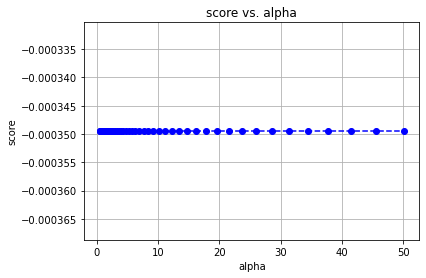

The optimaized alpha and score of Lasso linear is:  0.5011872336272722 -0.00034947287516851055
0.5011872336272722


In [109]:
# Lasso model select the optimized hyperparameters
alphas = np.logspace (-0.3, 1.7, num=50)
#Return numbers spaced evenly on a log scale.
scores = np.empty_like(alphas)

opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(scaled_train_X, scaled_train_y)
    scores[i] = lasso.score(scaled_test_X, scaled_test_y) # get scores for test dataset
    # lasso.score() Return the coefficient of determination R^2 of the prediction.
    # The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
    # A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
    if scores[i] > max_score: # lasso.score is r2 
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)
print(opt_a)

In [110]:
# use  optimal alpha, re-train the model
lasso_f = Lasso(alpha = opt_a)
lasso_f.fit(scaled_train_X, scaled_train_y)
lasso_pred = lasso_f.predict(scaled_test_X)

In [111]:
# define MAPE and MAD_ratio, and evalution result
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/(y_true+1)))*100

def mean_absolute_devation(arr):
    # Calculate the sum of absolute deviation about mean.
    absSum = 0
    for i in range(0, len(arr)):
        absSum = absSum + abs(arr[i] - np.mean(arr))
    return absSum / len(arr)

def mean_absolute_deviation_ratio(y_true, y_pred):
    return mean_absolute_devation(y_pred)/(mean_absolute_devation(y_true)+0.1)

def evaluate(test_price, prediction):
    test_price = np.exp(test_price)
    prediction = np.exp(prediction)
    MAPE = mean_absolute_percentage_error(test_price,prediction)
    print ('MAPE of 2019 Airbnb price is {}'.format(MAPE))  
    MAE = mean_absolute_error(test_price, prediction)
    print ('MAE of 2019 Airbnb price is {}'.format(MAE))   
    MAD_ratio = mean_absolute_deviation_ratio(test_price,prediction)
    print ('MAD ratio of prediction in 2019 Airbnb price is {}'.format(MAD_ratio))
 
    
def plot_diff(test_price, prediction, title1, title2):    # plot the pred vs. actual
    plt.plot(prediction,'o', color='red', alpha=0.3, label = 'predicted price')
    plt.plot(test_price,'*', color='blue', alpha=0.5, label = 'actual price')
    plt.title(title1)
    plt.legend(loc='upper right')
    plt.show()

    plt.plot((prediction - test_price)
             ,'v', color='green')
    plt.title(title2)
    plt.show()

In [112]:
evaluate(scaled_test_y, lasso_pred)

MAPE of 2019 Airbnb price is 60.692235091686605
MAE of 2019 Airbnb price is 79.11204092747265
MAD ratio of prediction in 2019 Airbnb price is 4.966660117086198e-16


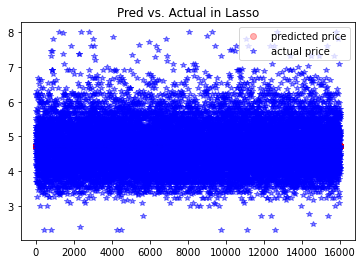

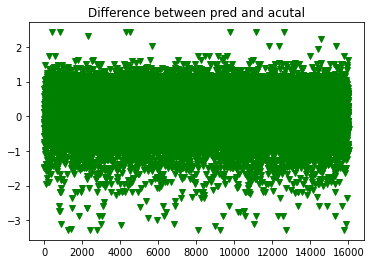

In [113]:
plot_diff(scaled_test_y, lasso_pred, 'Pred vs. Actual in Lasso', 'Difference between pred and acutal')

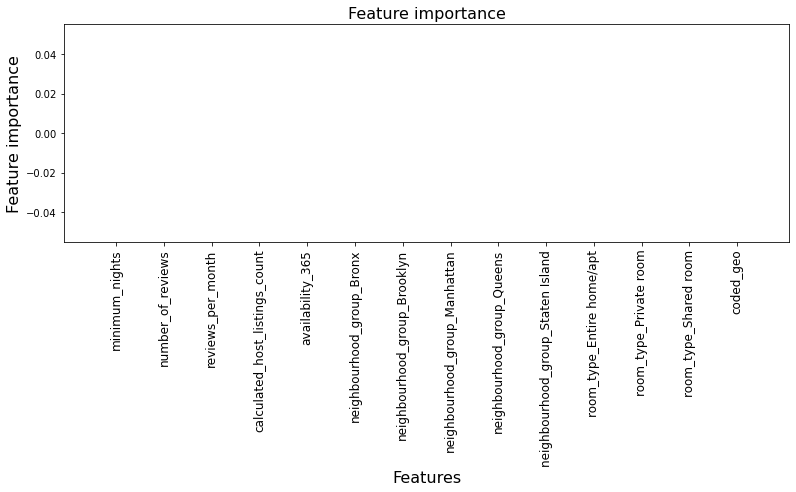

In [114]:
# get important features from linear regression
importance_lr_best = lasso_f.coef_
names_lr_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()

df_importantce_lr_best = pd.DataFrame({'Feature':names_lr_best, 'Importance':importance_lr_best})
# plot feature importance
rank_importance_lr_best = df_importantce_lr_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_lr_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')

#### 3.2 KNN

In [115]:
# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [116]:
parameters = { 'n_neighbors':[2,3,4,5,6,7,8,9] 
}
Grid_KNN = GridSearchCV(KNeighborsRegressor(),parameters, cv=5)
Grid_KNN.fit(scaled_train_X, scaled_train_y)
print_grid_search_metrics(Grid_KNN)
best_KNN_model = Grid_KNN.best_estimator_

Best score: 0.599492453804433
Best parameters set:
n_neighbors:9


In [117]:
knn_pred = best_KNN_model.predict(scaled_test_X)

In [118]:
evaluate(scaled_test_y, knn_pred)

MAPE of 2019 Airbnb price is 46.44149577439667
MAE of 2019 Airbnb price is 68.72270885271385
MAD ratio of prediction in 2019 Airbnb price is 0.605406699820693


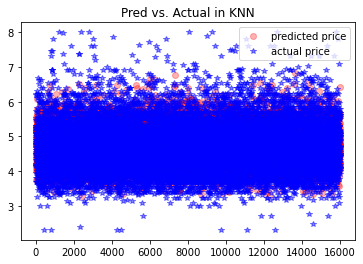

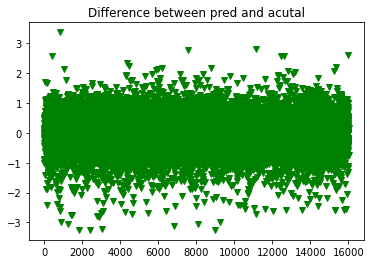

In [119]:
plot_diff(scaled_test_y, knn_pred, 'Pred vs. Actual in KNN', 'Difference between pred and acutal')

In [120]:
# perform permutation importance
from sklearn.inspection import permutation_importance
knn_results = permutation_importance(best_KNN_model, scaled_test_X, scaled_test_y, scoring='neg_mean_squared_error')
importance = knn_results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.02156
Feature: 1, Score: 0.00318
Feature: 2, Score: 0.00486
Feature: 3, Score: 0.01743
Feature: 4, Score: 0.03161
Feature: 5, Score: 0.00435
Feature: 6, Score: 0.01600
Feature: 7, Score: 0.02505
Feature: 8, Score: 0.00868
Feature: 9, Score: 0.00048
Feature: 10, Score: 0.12773
Feature: 11, Score: 0.11293
Feature: 12, Score: 0.01327
Feature: 13, Score: 0.00104


NameError: name 'pyplot' is not defined

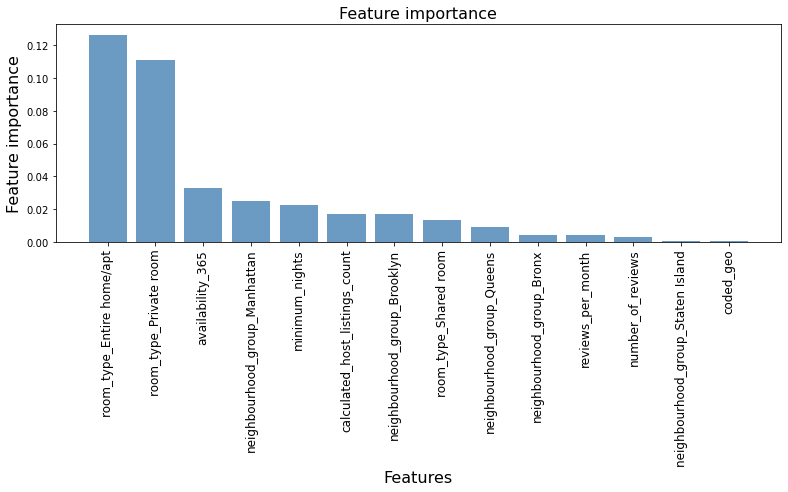

In [121]:
# get important features from knn
from sklearn.inspection import permutation_importance
knn_results = permutation_importance(best_KNN_model, scaled_test_X, scaled_test_y, scoring='neg_mean_squared_error')
importance_knn_best = knn_results.importances_mean
names_knn_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()

df_importantce_knn_best = pd.DataFrame({'Feature':names_knn_best, 'Importance':importance_knn_best})
# plot feature importance
rank_importance_knn_best = df_importantce_knn_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_knn_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')

#### 3.3 SVM

In [122]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['linear','RBF']}  
  
Grid_SVM = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3, cv =5) 


Grid_SVM.fit(scaled_train_X, scaled_train_y)
print_grid_search_metrics(Grid_SVM)
best_SVM_model = Grid_SVM.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.574, total=  25.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.0s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.578, total=  22.7s
[CV] C=0.1, gamma=1, kernel=linear ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.7s remaining:    0.0s


[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.604, total=  21.1s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.594, total=  21.4s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.583, total=  21.8s
[CV] C=0.1, gamma=1, kernel=RBF ......................................
[CV] ............ C=0.1, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=RBF ......................................
[CV] ............ C=0.1, gamma=1, kernel=RBF, score=nan, total=   0.1s
[CV] C=0.1, gamma=1, kernel=RBF ......................................
[CV] ............ C=0.1, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=RBF ......................................
[CV] ............ C=0.1, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=1, kernel=RBF ......................................


C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ............ C=0.1, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.574, total=  21.5s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.578, total=  21.2s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.604, total=  21.1s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.594, total=  21.4s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.583, total=  21.6s
[CV] C=0.1, gamma=0.1, kernel=RBF ....................................
[CV] .......... C=0.1, gamma=0.1, kernel=RBF, score=nan, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=RBF ....................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] .......... C=0.1, gamma=0.1, kernel=RBF, score=nan, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.574, total=  21.4s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.578, total=  21.4s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.604, total=  24.5s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.594, total=  24.0s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .... C=0.1, gamma=0.01, kernel=linear, score=0.583, total=  21.7s
[CV] C=0.1, gamma=0.01, kernel=RBF ...................................
[CV] ......... C=0.1, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=RBF ...................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ......... C=0.1, gamma=0.01, kernel=RBF, score=nan, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=RBF ...................................
[CV] ......... C=0.1, gamma=0.01, kernel=RBF, score=nan, total=   0.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................


C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.574, total=  23.7s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.578, total=  24.9s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.604, total=  21.3s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.594, total=  22.0s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ... C=0.1, gamma=0.001, kernel=linear, score=0.583, total=  22.7s
[CV] C=0.1, gamma=0.001, kernel=RBF ..................................
[CV] ........ C=0.1, gamma=0.001, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=RBF ..................................
[CV] ........ C=0.1, gamma=0.001, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=RBF ..................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ........ C=0.1, gamma=0.001, kernel=RBF, score=nan, total=   0.0s
[CV] C=0.1, gamma=0.001, kernel=RBF ..................................
[CV] ........ C=0.1, gamma=0.001, kernel=RBF, score=nan, total=   0.1s
[CV] C=1, gamma=1, kernel=linear .....................................


C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ......... C=1, gamma=1, kernel=linear, score=0.574, total=  53.2s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.578, total=  50.7s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.604, total=  49.5s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.594, total=  51.8s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ......... C=1, gamma=1, kernel=linear, score=0.583, total=  53.4s
[CV] C=1, gamma=1, kernel=RBF ........................................
[CV] .............. C=1, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=1, kernel=RBF ........................................
[CV] .............. C=1, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=1, kernel=RBF ........................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.574, total=  53.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.578, total=  50.7s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.604, total=  49.0s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.594, total=  52.6s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] ....... C=1, gamma=0.1, kernel=linear, score=0.583, total=  53.0s
[CV] C=1, gamma=0.1, kernel=RBF ......................................
[CV] ............ C=1, gamma=0.1, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=0.1, kernel=RBF ......................................
[CV] ............ C=1, gamma=0.1, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=0.1, kernel=RBF ......................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.574, total=  53.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.578, total=  51.0s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.604, total=  48.6s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.594, total=  51.9s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.583, total=  53.3s
[CV] C=1, gamma=0.01, kernel=RBF .....................................
[CV] ........... C=1, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=0.01, kernel=RBF .....................................
[CV] ........... C=1, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=0.01, kernel=RBF .....................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ........... C=1, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ..... C=1, gamma=0.001, kernel=linear, score=0.574, total=  53.0s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ..... C=1, gamma=0.001, kernel=linear, score=0.578, total=  50.9s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ..... C=1, gamma=0.001, kernel=linear, score=0.604, total=  50.8s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ..... C=1, gamma=0.001, kernel=linear, score=0.594, total=  52.4s
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ..... C=1, gamma=0.001, kernel=linear, score=0.583, total=  52.9s
[CV] C=1, gamma=0.001, kernel=RBF ....................................
[CV] .......... C=1, gamma=0.001, kernel=RBF, score=nan, total=   0.0s
[CV] C=1, gamma=0.001, kernel=RBF ....................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] .......... C=1, gamma=0.001, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.574, total= 4.8min
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.578, total= 4.8min
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.604, total= 4.9min
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.594, total= 5.0min
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.583, total= 5.0min
[CV] C=10, gamma=1, kernel=RBF .......................................
[CV] ............. C=10, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=1, kernel=RBF .......................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ............. C=10, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.574, total= 4.8min
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.578, total= 4.9min
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.604, total= 4.9min
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.594, total= 5.1min
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.583, total= 5.0min
[CV] C=10, gamma=0.1, kernel=RBF .....................................
[CV] ........... C=10, gamma=0.1, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=0.1, kernel=RBF .....................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ........... C=10, gamma=0.1, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.574, total= 4.9min
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.578, total= 4.9min
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.604, total= 4.9min
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.594, total= 5.0min
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ..... C=10, gamma=0.01, kernel=linear, score=0.583, total= 5.0min
[CV] C=10, gamma=0.01, kernel=RBF ....................................
[CV] .......... C=10, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=0.01, kernel=RBF ....................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] .......... C=10, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=0.01, kernel=RBF ....................................
[CV] .......... C=10, gamma=0.01, kernel=RBF, score=nan, total=   0.1s
[CV] C=10, gamma=0.001, kernel=linear ................................


C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] .... C=10, gamma=0.001, kernel=linear, score=0.574, total= 4.8min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.578, total= 4.8min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.604, total= 4.9min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.594, total= 5.0min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.583, total= 5.0min
[CV] C=10, gamma=0.001, kernel=RBF ...................................
[CV] ......... C=10, gamma=0.001, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=0.001, kernel=RBF ...................................
[CV] ......... C=10, gamma=0.001, kernel=RBF, score=nan, total=   0.1s
[CV] C=10, gamma=0.001, kernel=RBF ...................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ......... C=10, gamma=0.001, kernel=RBF, score=nan, total=   0.0s
[CV] C=10, gamma=0.001, kernel=RBF ...................................
[CV] ......... C=10, gamma=0.001, kernel=RBF, score=nan, total=   0.1s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.574, total=36.1min
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.578, total=36.2min
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.604, total=35.6min
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.594, total=36.5min
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.583, total=35.2min
[CV] C=100, gamma=1, kernel=RBF ......................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ............ C=100, gamma=1, kernel=RBF, score=nan, total=   0.0s
[CV] C=100, gamma=1, kernel=RBF ......................................
[CV] ............ C=100, gamma=1, kernel=RBF, score=nan, total=   0.1s
[CV] C=100, gamma=0.1, kernel=linear .................................


C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"


[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.574, total=35.2min
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.578, total=36.5min
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.604, total=35.6min
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.594, total=36.3min
[CV] C=100, gamma=0.1, kernel=linear .................................
[CV] ..... C=100, gamma=0.1, kernel=linear, score=0.583, total=35.2min
[CV] C=100, gamma=0.1, kernel=RBF ....................................
[CV] .......... C=100, gamma=0.1, kernel=RBF, score=nan, total=   0.0s
[CV] C=100, gamma=0.1, kernel=RBF ....................................
[CV] .......... C=100, gamma=0.1, kernel=RBF, score=nan, total=   0.0s
[CV] C=100, gamma=0.1, kernel=RBF ....................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] .......... C=100, gamma=0.1, kernel=RBF, score=nan, total=   0.1s
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.574, total=35.3min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.578, total=36.6min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.604, total=35.6min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.594, total=36.3min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] .... C=100, gamma=0.01, kernel=linear, score=0.583, total=35.4min
[CV] C=100, gamma=0.01, kernel=RBF ...................................
[CV] ......... C=100, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=100, gamma=0.01, kernel=RBF ...................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ......... C=100, gamma=0.01, kernel=RBF, score=nan, total=   0.0s
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ... C=100, gamma=0.001, kernel=linear, score=0.574, total=35.4min
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ... C=100, gamma=0.001, kernel=linear, score=0.578, total=36.5min
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ... C=100, gamma=0.001, kernel=linear, score=0.604, total=35.6min
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ... C=100, gamma=0.001, kernel=linear, score=0.594, total=36.3min
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ... C=100, gamma=0.001, kernel=linear, score=0.583, total=35.3min
[CV] C=100, gamma=0.001, kernel=RBF ..................................
[CV] ........ C=100, gamma=0.001, kernel=RBF, score=nan, total=   0.1s
[CV] C=100, gamma=0.001, kernel=RBF ..................................
[CV] .

C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 175, in sklearn.svm._libsvm.fit
ValueError: 'RBF' is not in list

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\williamshih\anaconda3\lib\site-packages\sklearn\model_selection\_v

[CV] ........ C=100, gamma=0.001, kernel=RBF, score=nan, total=   0.1s
Best score: 0.5866009085060249
Best parameters set:
C:0.1
gamma:1
kernel:linear


In [123]:
svm_pred = best_SVM_model.predict(scaled_test_X)

In [124]:
evaluate(scaled_test_y, svm_pred)

MAPE of 2019 Airbnb price is 47.20392797422275
MAE of 2019 Airbnb price is 71.88841666422233
MAD ratio of prediction in 2019 Airbnb price is 0.590850177593947


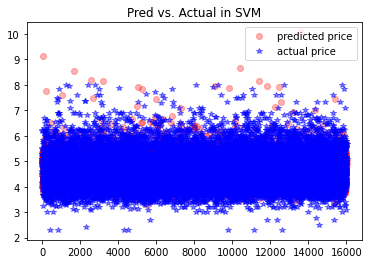

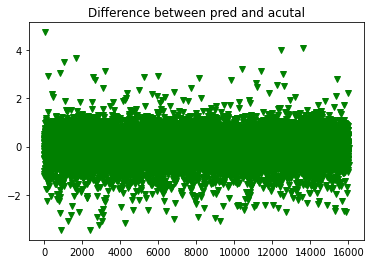

In [125]:
plot_diff(scaled_test_y, svm_pred, 'Pred vs. Actual in SVM', 'Difference between pred and acutal')

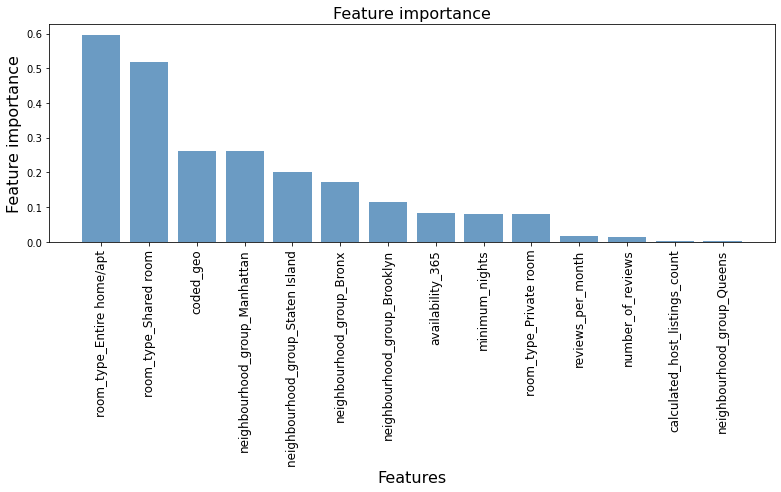

In [126]:
# get important features from SVM
importance_svm_best = abs(best_SVM_model.coef_[0])
names_svm_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()

df_importantce_svm_best = pd.DataFrame({'Feature':names_svm_best, 'Importance':importance_svm_best})
# plot feature importance
rank_importance_svm_best = df_importantce_svm_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_svm_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')

#### 3.4 Random Forest Regression

In [127]:
param_grid = {'n_estimators': [5,10,15,20,30,40],
          'max_depth': [30,40,45,50,55,60]}  
  
Grid_RF = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, refit = True, verbose = 3, cv =5) 


Grid_RF.fit(scaled_train_X, scaled_train_y)
print_grid_search_metrics(Grid_RF)
best_RF_model = Grid_RF.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=30, n_estimators=5 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ max_depth=30, n_estimators=5, score=0.540, total=   0.6s
[CV] max_depth=30, n_estimators=5 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ........ max_depth=30, n_estimators=5, score=0.546, total=   0.6s
[CV] max_depth=30, n_estimators=5 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ........ max_depth=30, n_estimators=5, score=0.559, total=   0.6s
[CV] max_depth=30, n_estimators=5 ....................................
[CV] ........ max_depth=30, n_estimators=5, score=0.556, total=   0.6s
[CV] max_depth=30, n_estimators=5 ....................................
[CV] ........ max_depth=30, n_estimators=5, score=0.550, total=   0.6s
[CV] max_depth=30, n_estimators=10 ...................................
[CV] ....... max_depth=30, n_estimators=10, score=0.581, total=   1.1s
[CV] max_depth=30, n_estimators=10 ...................................
[CV] ....... max_depth=30, n_estimators=10, score=0.574, total=   1.1s
[CV] max_depth=30, n_estimators=10 ...................................
[CV] ....... max_depth=30, n_estimators=10, score=0.588, total=   1.1s
[CV] max_depth=30, n_estimators=10 ...................................
[CV] ....... max_depth=30, n_estimators=10, score=0.590, total=   1.1s
[CV] max_depth=30, n_estimators=10 ...................................
[CV] .

[CV] ........ max_depth=45, n_estimators=5, score=0.541, total=   0.6s
[CV] max_depth=45, n_estimators=5 ....................................
[CV] ........ max_depth=45, n_estimators=5, score=0.540, total=   0.6s
[CV] max_depth=45, n_estimators=5 ....................................
[CV] ........ max_depth=45, n_estimators=5, score=0.559, total=   0.6s
[CV] max_depth=45, n_estimators=5 ....................................
[CV] ........ max_depth=45, n_estimators=5, score=0.556, total=   0.6s
[CV] max_depth=45, n_estimators=5 ....................................
[CV] ........ max_depth=45, n_estimators=5, score=0.548, total=   0.6s
[CV] max_depth=45, n_estimators=10 ...................................
[CV] ....... max_depth=45, n_estimators=10, score=0.582, total=   1.1s
[CV] max_depth=45, n_estimators=10 ...................................
[CV] ....... max_depth=45, n_estimators=10, score=0.572, total=   1.1s
[CV] max_depth=45, n_estimators=10 ...................................
[CV] .

[CV] ....... max_depth=50, n_estimators=40, score=0.618, total=   4.2s
[CV] max_depth=50, n_estimators=40 ...................................
[CV] ....... max_depth=50, n_estimators=40, score=0.610, total=   4.2s
[CV] max_depth=55, n_estimators=5 ....................................
[CV] ........ max_depth=55, n_estimators=5, score=0.541, total=   0.6s
[CV] max_depth=55, n_estimators=5 ....................................
[CV] ........ max_depth=55, n_estimators=5, score=0.540, total=   0.7s
[CV] max_depth=55, n_estimators=5 ....................................
[CV] ........ max_depth=55, n_estimators=5, score=0.559, total=   0.8s
[CV] max_depth=55, n_estimators=5 ....................................
[CV] ........ max_depth=55, n_estimators=5, score=0.556, total=   0.8s
[CV] max_depth=55, n_estimators=5 ....................................
[CV] ........ max_depth=55, n_estimators=5, score=0.548, total=   0.7s
[CV] max_depth=55, n_estimators=10 ...................................
[CV] .

[CV] ....... max_depth=60, n_estimators=40, score=0.602, total=   4.3s
[CV] max_depth=60, n_estimators=40 ...................................
[CV] ....... max_depth=60, n_estimators=40, score=0.618, total=   4.2s
[CV] max_depth=60, n_estimators=40 ...................................
[CV] ....... max_depth=60, n_estimators=40, score=0.618, total=   4.2s
[CV] max_depth=60, n_estimators=40 ...................................
[CV] ....... max_depth=60, n_estimators=40, score=0.610, total=   4.2s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  6.5min finished


Best score: 0.6110654682422951
Best parameters set:
max_depth:30
n_estimators:40


In [128]:
best_RF_model.fit(scaled_train_X, scaled_train_y)
rf_pred = best_RF_model.predict(scaled_test_X)

In [129]:
evaluate(scaled_test_y, rf_pred)

MAPE of 2019 Airbnb price is 51.4826626962355
MAE of 2019 Airbnb price is 73.2265275110606
MAD ratio of prediction in 2019 Airbnb price is 0.6467812308584285


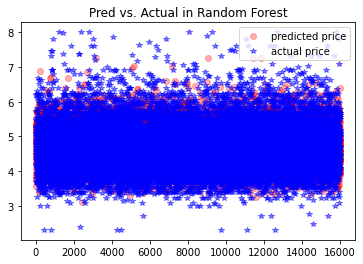

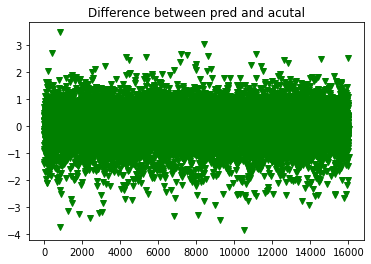

In [130]:
plot_diff(scaled_test_y, rf_pred, 'Pred vs. Actual in Random Forest', 'Difference between pred and acutal')

14
14


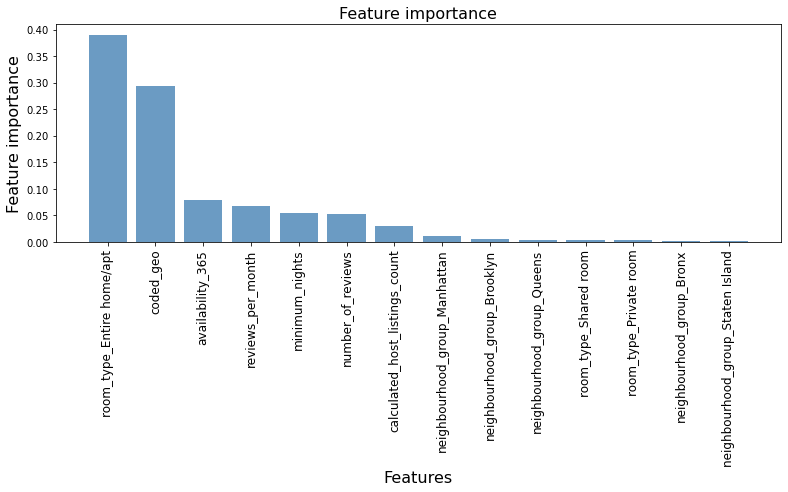

In [131]:
importance_rf_best = best_RF_model.feature_importances_
names_rf_best = scaled_train.loc[:, scaled_train.columns != 'price'].columns.tolist()
print(len(names_rf_best))
print(len(importance_rf_best))
df_importantce_rf_best = pd.DataFrame({'Feature':names_rf_best, 'Importance':importance_rf_best})
# plot feature importance
rank_importance_rf_best = df_importantce_rf_best.sort_values('Importance', ascending=False)

plot_feature_importance(rank_importance_rf_best,15, 'steelblue', 0.8, 13, 4, 'Feature importance')